In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pathresults = "../../results/"
#pathresults = "/DUMUXDune27/DUMUX/dumux-rosi/python/paperSc/results/"
data_file_delimiter = ","
import re

evalTime = 25.

#path2file_ = r'newMucil/{}_1476_{}_10to11_20mn_0s_10/'

#path2file_ = r'CSTiminSame_exud4p/{}_1476_{}_10to25_20mn_0s_128/'


In [154]:
def getVal(mypath, filename,dtype=float,extension='.txt', header="infer",names = None):
    fullpath = pathresults +mypath+filename
    data_file_delimiter = ","
    if names is None:
        largest_column_count = 0
        with open(fullpath, 'r') as temp_f:
            lines = temp_f.readlines()
        last_line = lines[-1].strip()
        #print('last_line',last_line)
        array_from_last_line = np.array(last_line.split(','), dtype=dtype)
        largest_column_count = len(array_from_last_line)
        names = [i for i in range(0, largest_column_count)]
        cst = pd.read_csv(fullpath,delimiter=data_file_delimiter, 
                          header = header, names = names)
        #print('cst',cst.shape)
    else:
        cst = pd.read_csv(fullpath,delimiter=data_file_delimiter, header = header, names = names)
    return cst
    
def get_last_line_as_numpy_array(file_path,  dtype = float, verbose = False):
    with open(pathresults +file_path, 'r') as file:
        # Read all lines
        lines = file.readlines()

        # Check if there are any lines in the file
        if not lines:
            raise ValueError("The file is empty")

        # Get the last line
        
        try:
            last_line = lines[-1].strip()
        except:
            print('timeLine',file_path, len(lines))
            raise Exception

        # Split the last line by commas and convert to NumPy array
        array_from_last_line = np.array(last_line.split(','), dtype=dtype)
        if verbose:
            print(file_path, len(array_from_last_line), end=", ")

        return array_from_last_line

def getCylIdx(path2file):
    fileName = "rhizoSegsId.txt"
    fullpath = path2file+fileName
    rhizoSegsId = get_last_line_as_numpy_array(fullpath, dtype = int, verbose = True)
    print('rhizoSegsId',max(rhizoSegsId))
    return rhizoSegsId
    
def list_files_with_prefix(folder_path, prefix):
    file_names = []
    for file_name in os.listdir(pathresults+folder_path):
        if file_name.startswith(prefix):
            file_names.append(file_name)
    return file_names

# cylinder max konz (per cell)
def getData_(cid,gId,path2file):
    fileName = "cyl_val/Cyl_cellVol_"+str(gId)+".txt"
    cVol = get_last_line_as_numpy_array(path2file+fileName, dtype = float)
    if cid == volIdx:
        return sum(cVol)
    elif cid <= 9:
        if cid <= 2:# == 0:
            fileName = "cyl_val/Cyl_watercontent_"+str(gId)+".txt"
            theta = get_last_line_as_numpy_array(path2file+fileName,dtype = float)
            cVol *= theta#cm3 scv to cm3 water
            if cid == 0:
                return sum(cVol)
        fileName = "cyl_val/Cyl_content"+str(cid)+"_"+str(gId)+".txt"
        Q1 = get_last_line_as_numpy_array(path2file+fileName,  dtype = float)
        konz = sum(Q1)/sum(cVol) #mol/cm3 or cm3/cm3
        return konz
    raise Exception

plantData = {0:'Q_Ag',1:'Q_Rm',2:'Q_Gr',3: 'Q_Exud_tot', 4:'Q_Mucil_tot',
             5:'Q_Exud',
             6:'Q_Mucil',
             7:'Q_S_ST',
             8:'Q_S_meso',
             9:'trans' ,10:'psiXyl',
             11:'time',
             12:'pSet',13:'scenario', }

extensions = {0:'.txt',1:'.txt',2:'.txt',3: '.txt', 4:'.txt',
             5:'.txt',
             6:'.txt', 7:'.txt',8:'.txt', 9:'.txt', 10:'.txt',
              11:'.txt',12:'.txt',13:'.txt'}
colNames=np.array(list(plantData.values()))
nToGet = len(plantData)-3 # all except pset and scenario

scenarios = [ "baseline", "lateDry","earlyDry"]
setIds =[5,61]# ,44,49 [7,21, 47, 85]
exceptPset = []#[('baseline','19'),('baseline','47'),('baseline','83')]
#result_list_compExcept = [path2file.format(scenario, str(setId)) for scenario, setId in exceptPsets]
dataInput =  [(scenario, str(setId)) for scenario in scenarios 
              for setId in setIds if (scenario, str(setId)) 
              not in exceptPset ]
#result_list_comp = [path2file.format(dI[0], dI[1]) 
#                    for dI in dataInput]

#numPset = len(dataInput)


def getData():
    
    GiniAll = [[] for i in range(len(dataInput))]
    
    for idSet, dI in enumerate(dataInput):
        GiniAll_ = pd.DataFrame(columns=colNames)
        print(idSet,end =", ")

        path2file = path2file_.format(dI[0], dI[1])
        #print(path2file)

        time = np.array(list(
            pd.read_csv(pathresults + path2file + "time.txt", 
                           names = ["time","Qlight"])["time"][1:])) # because we have twice the initial value
        timemax = int((max(time))*10)/10
        print('timemax',max(time),timemax, len(time))
        
        if(True):#timemax==25):


            for cid in range(nToGet):
                if (plantData[cid] == 'psiXyl'):
                    Ginits = getVal(path2file,plantData[cid]+'.txt'#extensions[cid]
                            ).mean(axis=1)
                else:
                    Ginits = getVal(path2file,plantData[cid]+'.txt'#extensions[cid]
                            ).sum(axis=1)
                #print(plantData[cid])#,Ginits,type(Ginits))
                GiniAll_[plantData[cid]]= Ginits
            Q_Exud_mean = getVal(path2file,"Q_Exud.txt")
            
            GiniAll_['Q_Exud_mean'] = Q_Exud_mean[Q_Exud_mean>0].mean(axis=1)
            GiniAll_[plantData[nToGet]]= time[:len(GiniAll_[plantData[nToGet]])]
            GiniAll_[plantData[nToGet+1]]= dI[1]
            GiniAll_[plantData[nToGet+2]]= dI[0]
            
        GiniAll[idSet] = GiniAll_
    return GiniAll #cid pSet rr
    


In [159]:
min(Q_Exud_mean[Q_Exud_mean>0].mean(axis=1))

9.825077096811317e-08

In [155]:
#path2file_ = r'getsrivssriset/{}_1476_{}_10to25_20mn_0s_64/'
#path2file_ = r'testspeed/thr4{}_1476_{}_10to25_20mn_0s_32/'
#path2file_ = r'checkCbalance/{}_1476_{}_10to25_20mn_0s_32/'
path2file_ = r'checkCbalanceWrsi1perr/{}_1476_{}_10to25_20mn_0s_32/'
setIds =[5,44,61]
dataInput =  [(scenario, str(setId)) for scenario in scenarios 
              for setId in setIds if (scenario, str(setId)) 
              not in exceptPset ]
GiniAll = getData()
dftemp=[]
for Gini in GiniAll:
    dftemptemp=pd.DataFrame(Gini)
    dftemp.append(dftemptemp)

0, timemax 25.000000000000423 25.0 1080
1, timemax 25.000000000000423 25.0 1080
2, timemax 25.000000000000423 25.0 1080
3, timemax 25.000000000000423 25.0 1080
4, timemax 25.000000000000423 25.0 1080
5, timemax 25.000000000000423 25.0 1080
6, timemax 25.000000000000423 25.0 1080
7, timemax 25.000000000000423 25.0 1080
8, timemax 25.000000000000423 25.0 1080


In [132]:
for ddd in dataInput:
    pp = path2file_.format(ddd[0],ddd[1])
    fileName = "Q_Exud_tot.txt"
    print(ddd[0]+ddd[1],"=",get_last_line_as_numpy_array(pp+fileName)[0])
print()
for ddd in dataInput:
    pp = path2file_.format(ddd[0],ddd[1])
    fileName = "Q_Mucil_tot.txt"
    print(ddd[0]+ddd[1],"=",get_last_line_as_numpy_array(pp+fileName)[0])

baseline5 = 0.012385128700889933
baseline44 = 0.012385128700889933
baseline61 = 0.012385128700889933
lateDry5 = 0.016005937706584393
lateDry44 = 0.016010738713939255
lateDry61 = 0.01558911486684513
earlyDry5 = 0.008307738898438624
earlyDry44 = 0.008268212213344752
earlyDry61 = 0.0077888048148938025

baseline5 = 0.000153251320805056
baseline44 = 0.000153251320805056
baseline61 = 0.000153251320805056
lateDry5 = 0.0003664624825829944
lateDry44 = 0.0003665956672119942
lateDry61 = 0.0004093326934143415
earlyDry5 = 0.00013368842152262344
earlyDry44 = 0.00014006125190772572
earlyDry61 = 0.00016255721243144136


In [138]:

for ddd in dataInput:
    pp = path2file_.format(ddd[0],ddd[1])
    fileName = "Q_Mucil_tot.txt"
    qmuciltot = get_last_line_as_numpy_array(pp+fileName)[0]
    fileName = "Q_Exud_tot.txt"
    qexudtot = get_last_line_as_numpy_array(pp+fileName)[0]
    print(ddd[0]+ddd[1],"=",qmuciltot/qexudtot*100.) # [1-10]%
print()#Q_Ag
for ddd in dataInput:
    pp = path2file_.format(ddd[0],ddd[1])
    fileName = "Q_Ag.txt"
    
    qagtot = get_last_line_as_numpy_array(pp+fileName)[0]
    fileName = "Q_Exud_tot.txt"
    qexudtot = get_last_line_as_numpy_array(pp+fileName)[0]
    print(ddd[0]+ddd[1],"=",qexudtot/qagtot*100.) # [3-40]%

baseline5 = 1.2373817382619863
baseline44 = 1.2373817382619863
baseline61 = 1.2373817382619863
lateDry5 = 2.289540852281601
lateDry44 = 2.2896861522874583
lateDry61 = 2.625759684951124
earlyDry5 = 1.6092034566438909
earlyDry44 = 1.6939726302823876
earlyDry61 = 2.087062345182902

baseline5 = 16.973636132417365
baseline44 = 16.973636132417365
baseline61 = 16.973636132417365
lateDry5 = 35.56464814179896
lateDry44 = 35.56970814166006
lateDry61 = 34.637762259343226
earlyDry5 = 21.382122172773606
earlyDry44 = 21.307754952417454
earlyDry61 = 19.94899091921343


In [139]:
import string
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter
from matplotlib.transforms import ScaledTranslation
l_styles = {5:'-',44:'--',61:':'}
# Define the color dictionary
c_styles = {
    'baseline':'#8da0cb',  # Blue
    'earlyDry':  '#66c2a5' ,  # Green
    'lateDry': '#fc8d62'  # red
}


color_legend_elements = [
    Line2D([0], [0], color=c_styles['baseline'], lw=6, label='baseline'),
    Line2D([0], [0], color=c_styles['earlyDry'], lw=6, label='earlyDry'),
    Line2D([0], [0], color=c_styles['lateDry'], lw=6, label='lateDry')
]

# Line style legend
linestyle_legend_elements = [
    Line2D([0], [0], color='black', linestyle=l_styles[5], lw=6, label=5),
    #Line2D([0], [0], color='black', linestyle=l_styles[38], lw=6, label=38),
    Line2D([0], [0], color='black', linestyle=l_styles[44], lw=6, label=44),
    Line2D([0], [0], color='black', linestyle=l_styles[61], lw=6, label=61)
]

def dotheplot(toplot, cumsum,df, sizerows,sizecols_,namesyaxes=None,ncols=3, maxTime = None, 
              indexlegend1=0, indexlegend2=1):
    nrows = len(toplot)
    #ncols = 3
    scenarios = [ "baseline","earlyDry", "lateDry"]
    sizecols = sizecols_*ncols

    cm3tommol = 1000*(1/18.01528)

    # higher than in the 1st paper
    # probably in part because i increased the kr of the roots
    cm3tommol = 1000*(1/18.01528)
    ratioTrans = 250 
    
    fig, ax = plt.subplots(nrows, ncols,figsize=(sizerows,sizecols))  # 2 rows, 2 columns
    for ddid, dd in enumerate(df):
        for rowid, tipi in enumerate(toplot): 
            try:
                pset_ = int(dd['pSet'].unique()[0])
            except:
                print('rowid', rowid,tipi)
                print(dd['pSet'].unique())
            scenario_ = dd['scenario'].unique()[0]
            if ncols > 1:
                colid = np.where(scenario_==np.array(scenarios))[0][0]
            else:
                colid = 0
            factor = 1000
            rot = 0
            unit=" (mmol C)"
            if (tipi == "trans" )or (tipi =='psiXyl'):
                factor = cm3tommol
                unit = " (cm3)"
                
            if tipi == "psiXyl":
                factor = 1.
                rot =30
                unit = " (cm)"
            ddd = dd[tipi]*factor
            tts = dd['time']
            if not cumsum:
                tts = dd['time'][1:]
                ddd = np.diff(ddd)*4
            
            if ncols > 1:
                ax_ = ax[rowid, colid]
            else:
                ax_ = ax[rowid]
            ax_.plot( tts,ddd,
                                                             linewidth=3,
                         #label=f'{i}',
                         c=c_styles[dd['scenario'].unique()[0]],
                         linestyle=l_styles[int(dd['pSet'].unique()[0])]
                    )
            
                
            ax_.tick_params(axis='both', which='major', labelsize=18)
            ax_.tick_params(axis='y', which='major', labelrotation=rot, labelsize=18)
            if colid == 0:
                if namesyaxes is not None:
                    ax_.set_ylabel(namesyaxes[tipi]+unit, fontsize=20)
                else:
                    ax_.set_ylabel(tipi+unit, fontsize=20)
            if rowid == 0 and ncols > 1:
                ax_.set_title(scenario_)
            if rowid == nrows-1:
                ax_.set_xlabel('time (d)', fontsize=20)
            if True:
                if scenario_ == "lateDry":
                    ax_.axvline(x=18, color='k', linestyle='--')
                    ax_.axvline(x=25, color='k', linestyle='--')
                if scenario_ == "earlyDry":
                    ax_.axvline(x=18, color='k', linestyle='--')
                    ax_.axvline(x=11, color='k', linestyle='--')
            if maxTime is not None:
                ax_.set_xlim(10, maxTime)
                
            if rowid + colid == indexlegend1:
                ax_.legend(handles=color_legend_elements, 
                                                           fontsize=20,title_fontsize='25', title='scenario', 
                                                           loc='upper center',  ncol=3)#bbox_to_anchor=(0.5, -0.15),
                
            if rowid + colid == indexlegend2:
                ax_.legend(handles=linestyle_legend_elements, 
                                                           fontsize=20,title_fontsize='25', title='parameter set', 
                                                           loc='upper center',  ncol=3)#bbox_to_anchor=(0.5, -0.3),
                if False:
                    
                    ax_.add_artist(plt.legend(handles=color_legend_elements, 
                                                                              fontsize=20, title='scenario', 
                                                                               title_fontsize='25',
                                                                              loc='upper center',# bbox_to_anchor=anchor1,#(0.5, -0.15), 
                                                                              ncol=3, framealpha=1))
                    ax_.add_artist(plt.legend(handles=linestyle_legend_elements, 
                                                                              fontsize=20, title='parameter set', 
                                                                               title_fontsize='25',
                                                                              loc='upper center',# bbox_to_anchor=anchor2,#(0.5, -0.3), 
                                                                              ncol=3, framealpha=1))

                #ax_.legend() 
            index = rowid * ncols + colid
            # Get the corresponding letter label
            label = string.ascii_uppercase[index]
            ax_.annotate(
                    label,
                    xy=(0, 1), xycoords='axes fraction',
                    xytext=(+0.5, -0.5), textcoords='offset fontsize',
                    fontsize='20', verticalalignment='top', fontfamily='serif',
                    bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))
    plt.tight_layout()

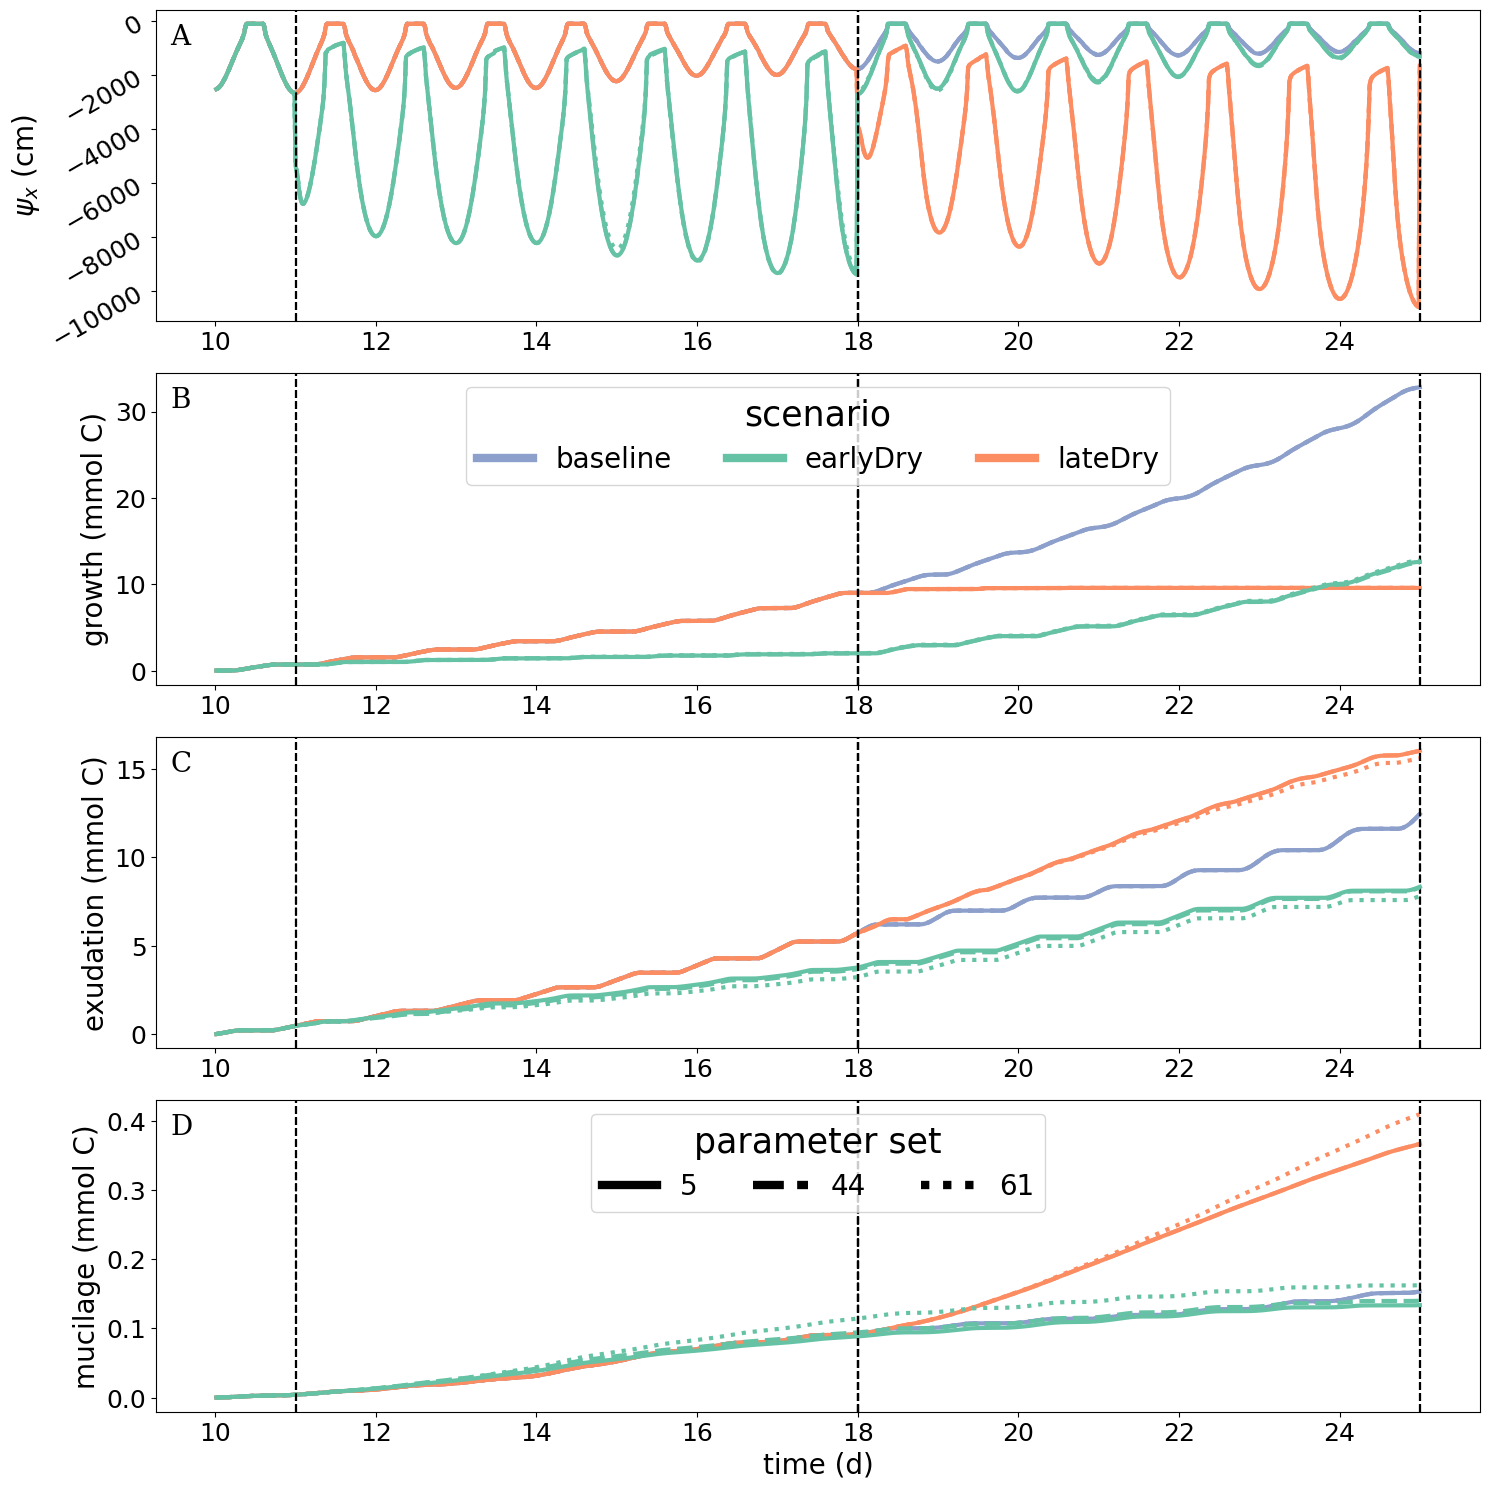

In [140]:
dotheplot(toplot =  ['psiXyl','Q_Gr','Q_Exud','Q_Mucil'],
          namesyaxes={'psiXyl':"$\psi_x$", 'Q_Gr':"growth", 'Q_Exud':"exudation",'Q_Mucil': "mucilage"},
          cumsum=True, df=dftemp, sizerows=15,sizecols_=15,ncols=1, indexlegend1=1, indexlegend2=3)
plt.savefig('Cusage.png')

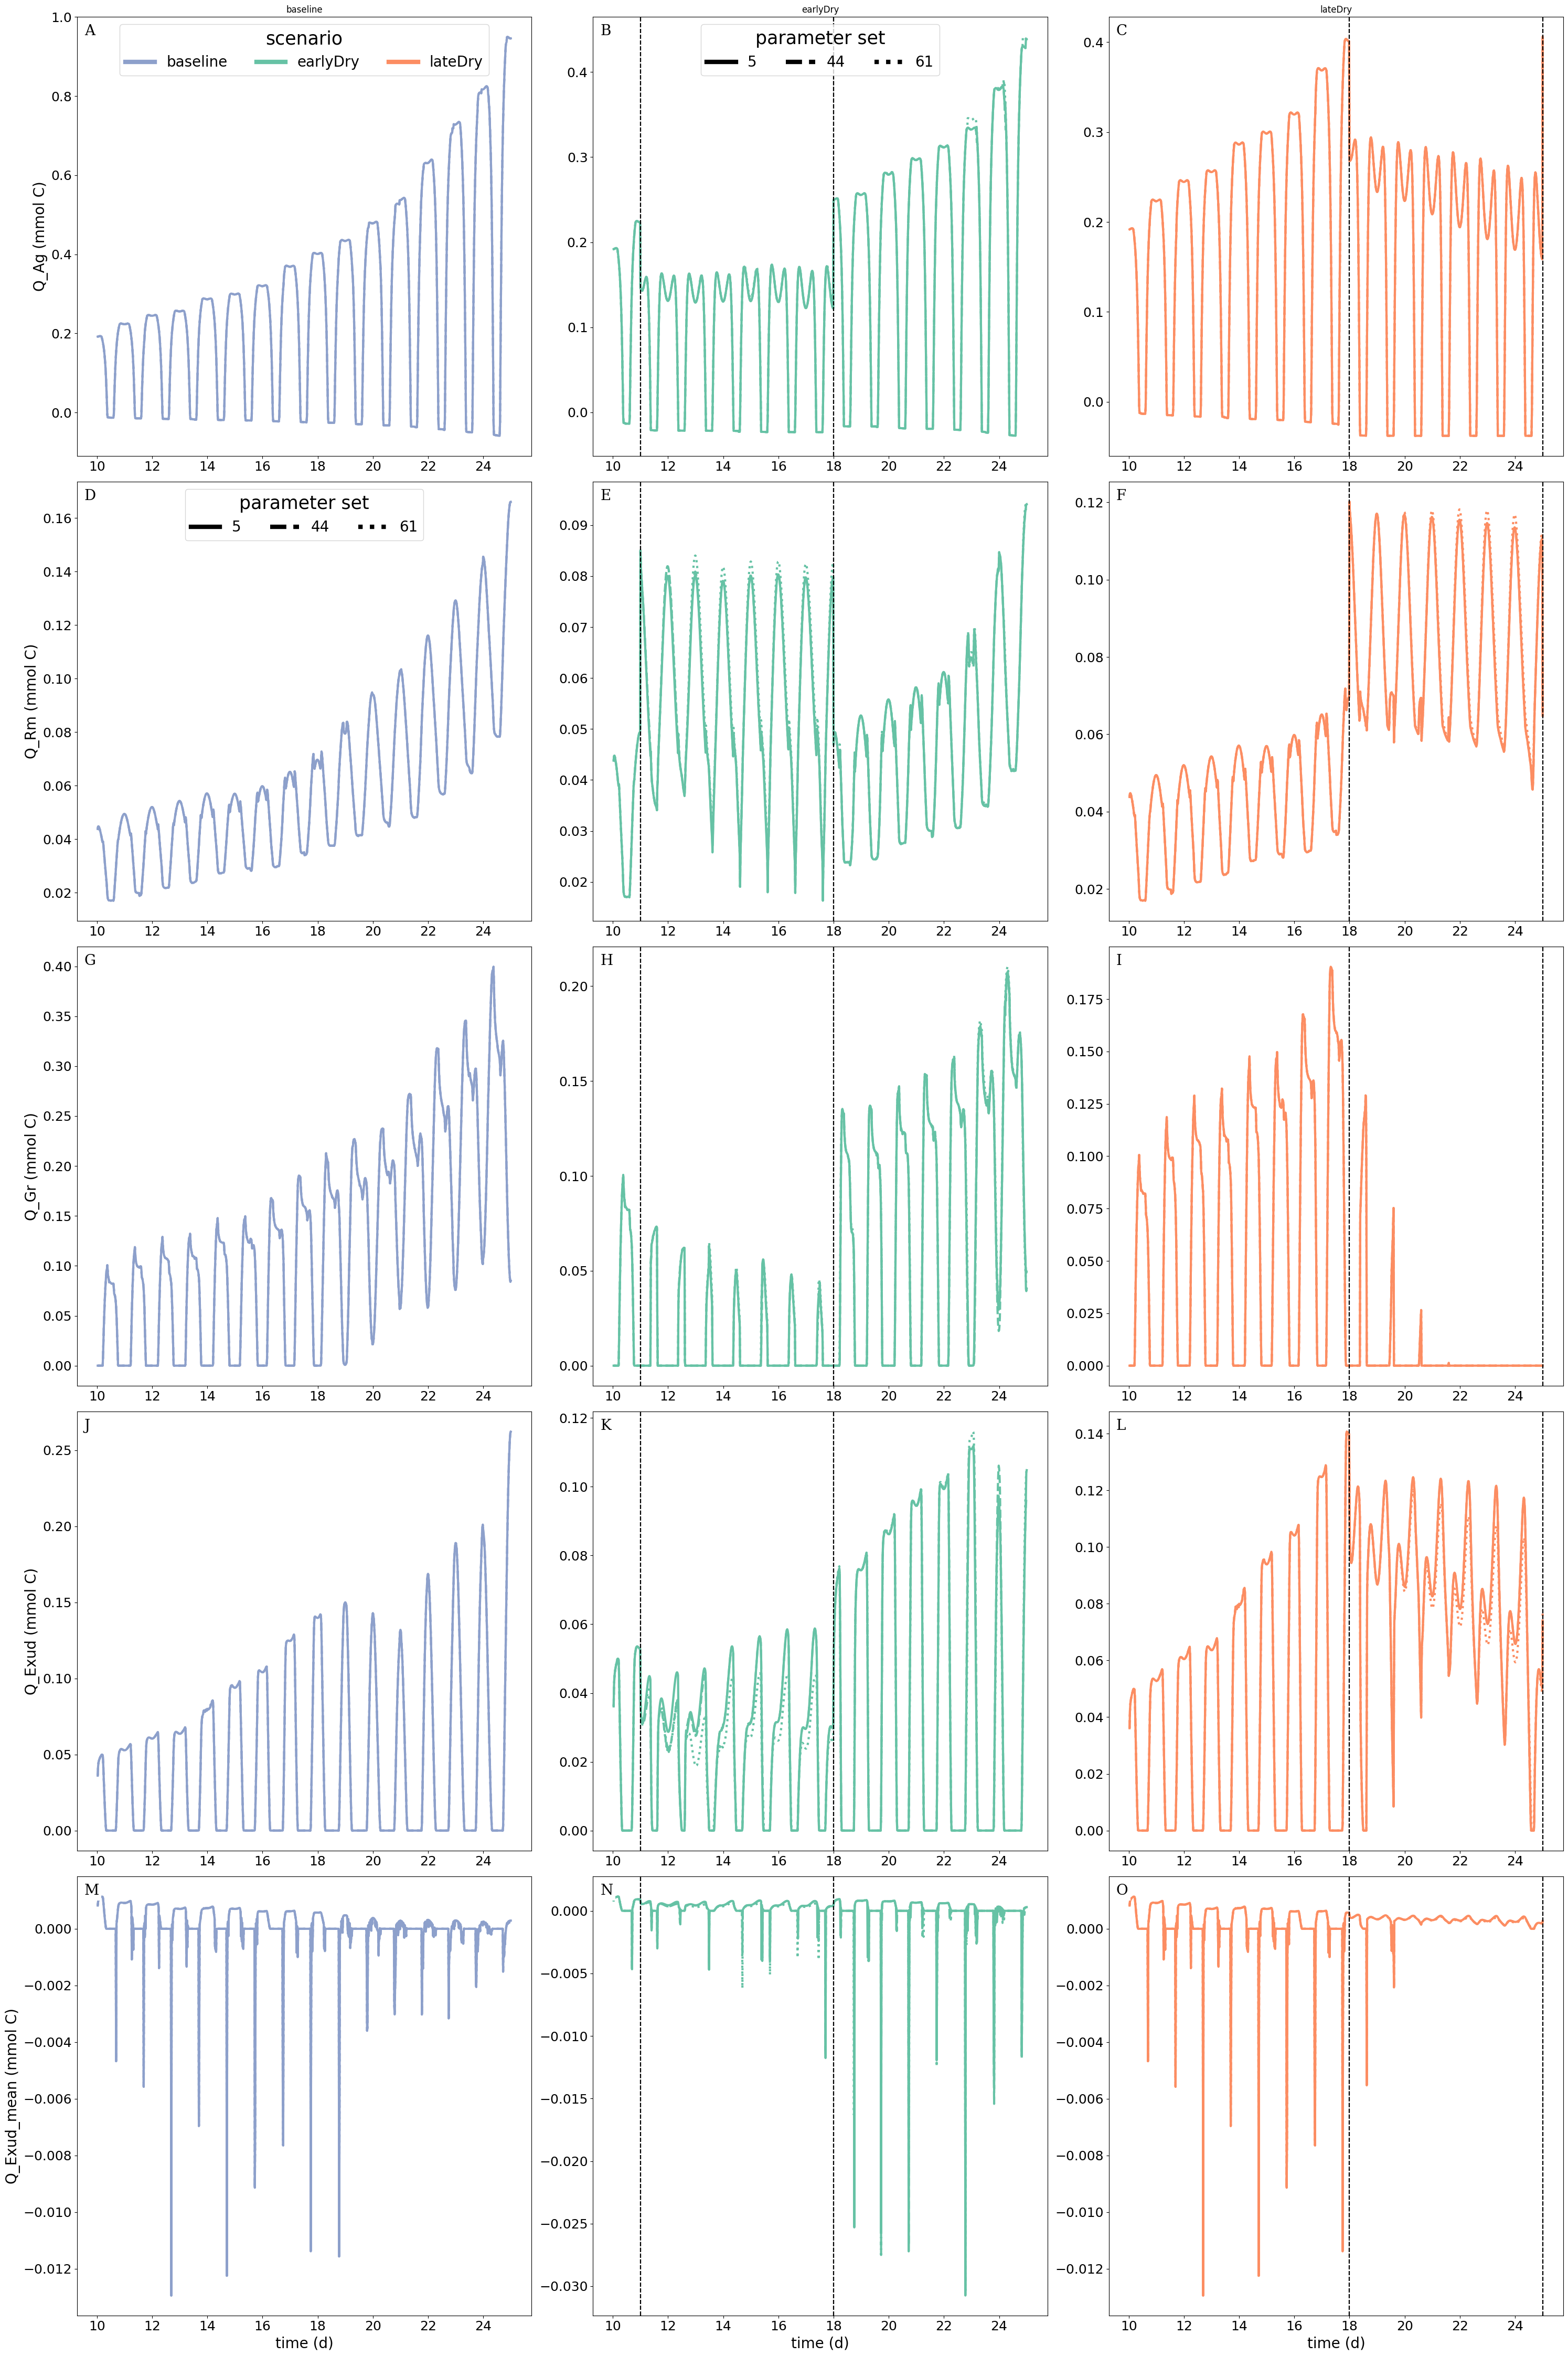

In [156]:

dotheplot(toplot =  ['Q_Ag','Q_Rm','Q_Gr','Q_Exud', 'Q_Exud_mean'],
          cumsum=False, df=dftemp, sizerows=30,sizecols_=15)

In [109]:
df44late=dftemp[4].copy()
df44early=dftemp[7].copy()
df44late = df44late[(df44late['time'] >= 18 )&(df44late['time'] <=25)].reset_index(drop=True)
df44early = df44early[(df44early['time'] >= 11. )&(df44early['time'] <=18)].reset_index(drop=True)
df44late['time']= np.round(df44late['time']-18,6) 
df44early['time']= np.round(df44early['time'] - 11,6) 

In [110]:
df44earlylate = pd.merge(df44late,df44early, on="time")

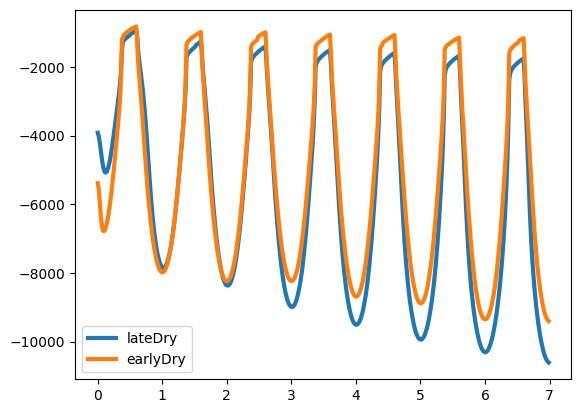

In [111]:
plt.plot( df44earlylate['time'], df44earlylate['psiXyl_x'],linewidth=3,
                         label=f"{df44earlylate['scenario_x'].unique()[0]}",
                    )
plt.plot( df44earlylate['time'], df44earlylate['psiXyl_y'],linewidth=3,
                         label=f"{df44earlylate['scenario_y'].unique()[0]}",
                    )
plt.legend()

In [69]:
df44early

Q_Ag      Q_Rm      Q_Gr  Q_Exud_tot  Q_Mucil_tot    Q_Exud  \
71   0.002292  0.000609  0.000694    0.000457     0.000004  0.000468   
72   0.002328  0.000629  0.000694    0.000468     0.000004  0.000477   
73   0.002364  0.000649  0.000694    0.000477     0.000004  0.000485   
74   0.002400  0.000669  0.000694    0.000485     0.000004  0.000493   
75   0.002436  0.000689  0.000694    0.000493     0.000004  0.000501   
..        ...       ...       ...         ...          ...       ...   
570  0.014254  0.007774  0.002009    0.003384     0.000107  0.003392   
571  0.014285  0.007794  0.002009    0.003392     0.000107  0.003399   
572  0.014317  0.007814  0.002009    0.003399     0.000107  0.003407   
573  0.014348  0.007834  0.002009    0.003407     0.000107  0.003414   
574  0.014379  0.007854  0.002009    0.003414     0.000107  0.003422   

      Q_Mucil    Q_S_ST  Q_S_meso     trans       psiXyl          time pSet  \
71   0.000004  0.000190  0.000595  0.659706 -5386.519053  2.842171e-14   44   
72   0.000004  0.000194  0.000613  0.695812 -5550.980872  1.388889e-02   44   
73   0.000004  0.000197  0.000627  0.730556 -5852.412940  2.777778e-02   44   
74   0.000004  0.000201  0.000640  0.763527 -6203.777314  4.166667e-02   44   
75   0.000004  0.000204  0.000650  0.794745 -6494.917612  5.555556e-02   44   
..        ...       ...       ...       ...          ...           ...  ...   
570  0.000107  0.001333  0.000000  7.887086 -9121.760411  6.930556e+00   44   
571  0.000107  0.001335  0.000000  7.908231 -9196.376070  6.944444e+00   44   
572  0.000107  0.001337  0.000000  7.929337 -9254.173773  6.958333e+00   44   
573  0.000107  0.001339  0.000000  7.950388 -9296.037919  6.972222e+00   44   
574  0.000108  0.001342  0.000000  7.971371 -9322.107138  6.986111e+00   44   

     scenario  
71   earlyDry  
72   earlyDry  
73   earlyDry  
74   earlyDry  
75   earlyDry  
..        ...  
570  earlyDry  
571  earlyDry  
572  earlyDry  
573  earlyDry  
574  earlyDry  

[504 rows x 14 columns]

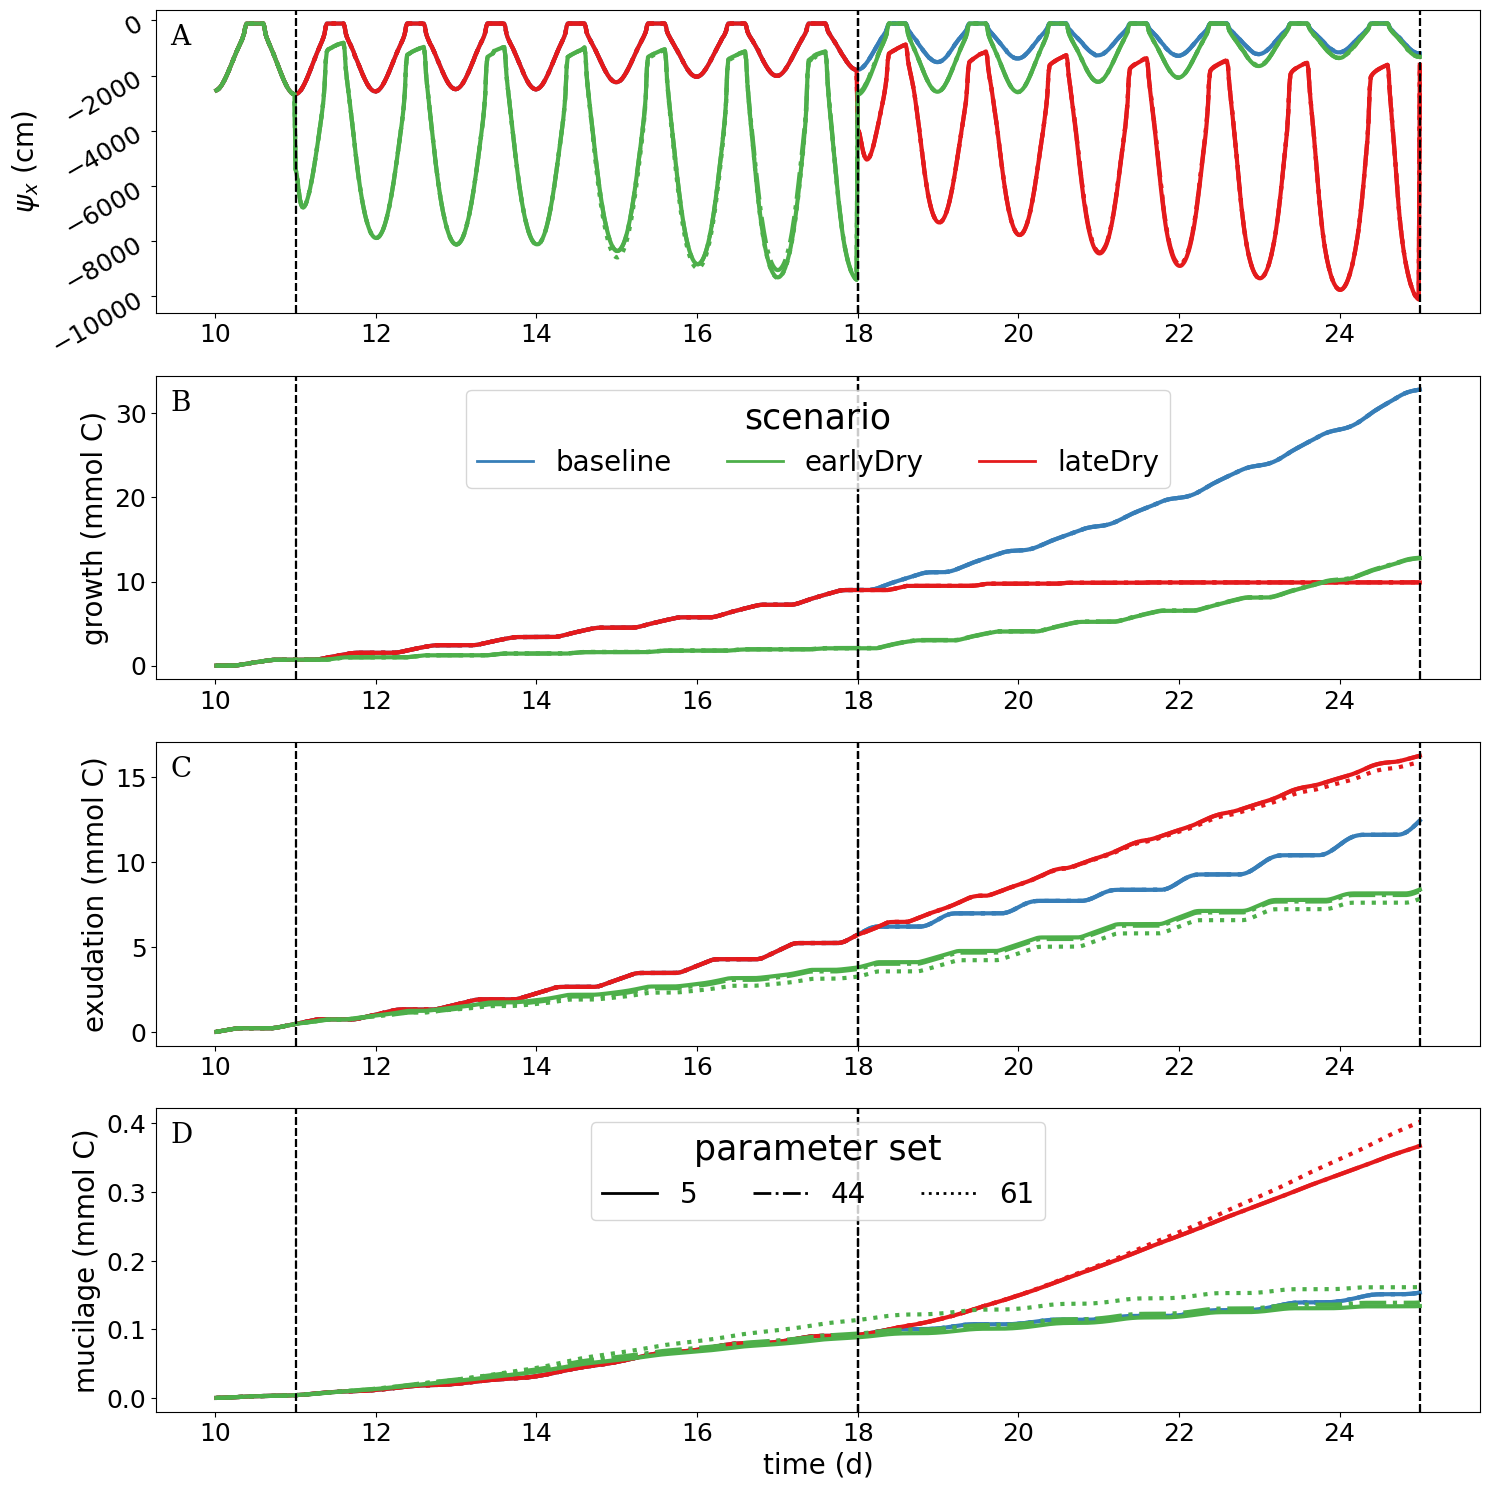

In [30]:

dotheplot(toplot =  ['psiXyl','Q_Gr','Q_Exud','Q_Mucil'],
          namesyaxes={'psiXyl':"$\psi_x$", 'Q_Gr':"growth", 'Q_Exud':"exudation",'Q_Mucil': "mucilage"},
          cumsum=True, df=dftemp, sizerows=15,sizecols_=15,ncols=1, indexlegend1=1, indexlegend2=3)

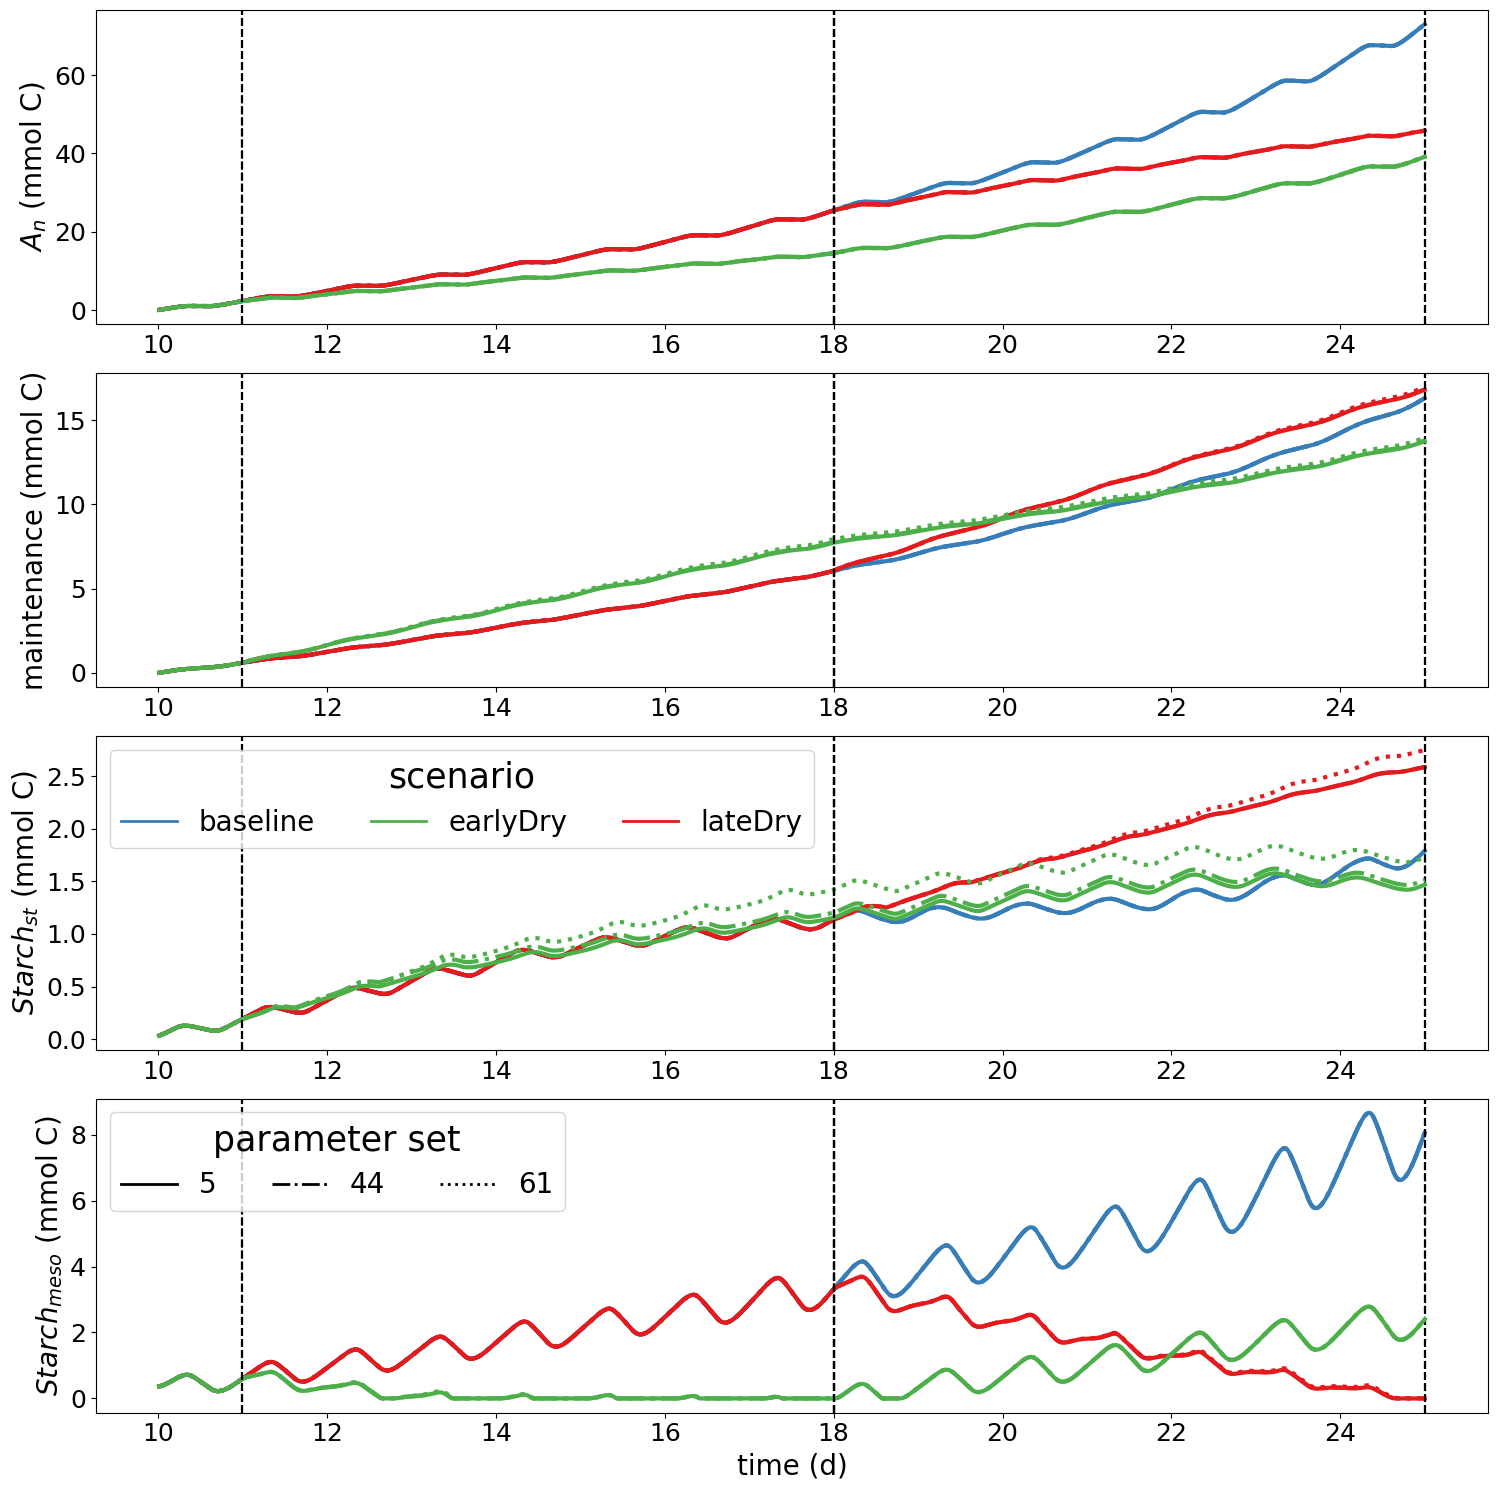

In [76]:

dotheplot(toplot =  ['Q_Ag','Q_Rm','Q_S_ST', 'Q_S_meso'],
          namesyaxes={'Q_Ag':"$A_n$", 'Q_Rm':"maintenance", 'Q_S_ST':"$Starch_{st}$",'Q_S_meso': "$Starch_{meso}$"},
          cumsum=True, df=dftemp, sizerows=15,sizecols_=15,ncols=1, indexlegend1=2, indexlegend2=3)

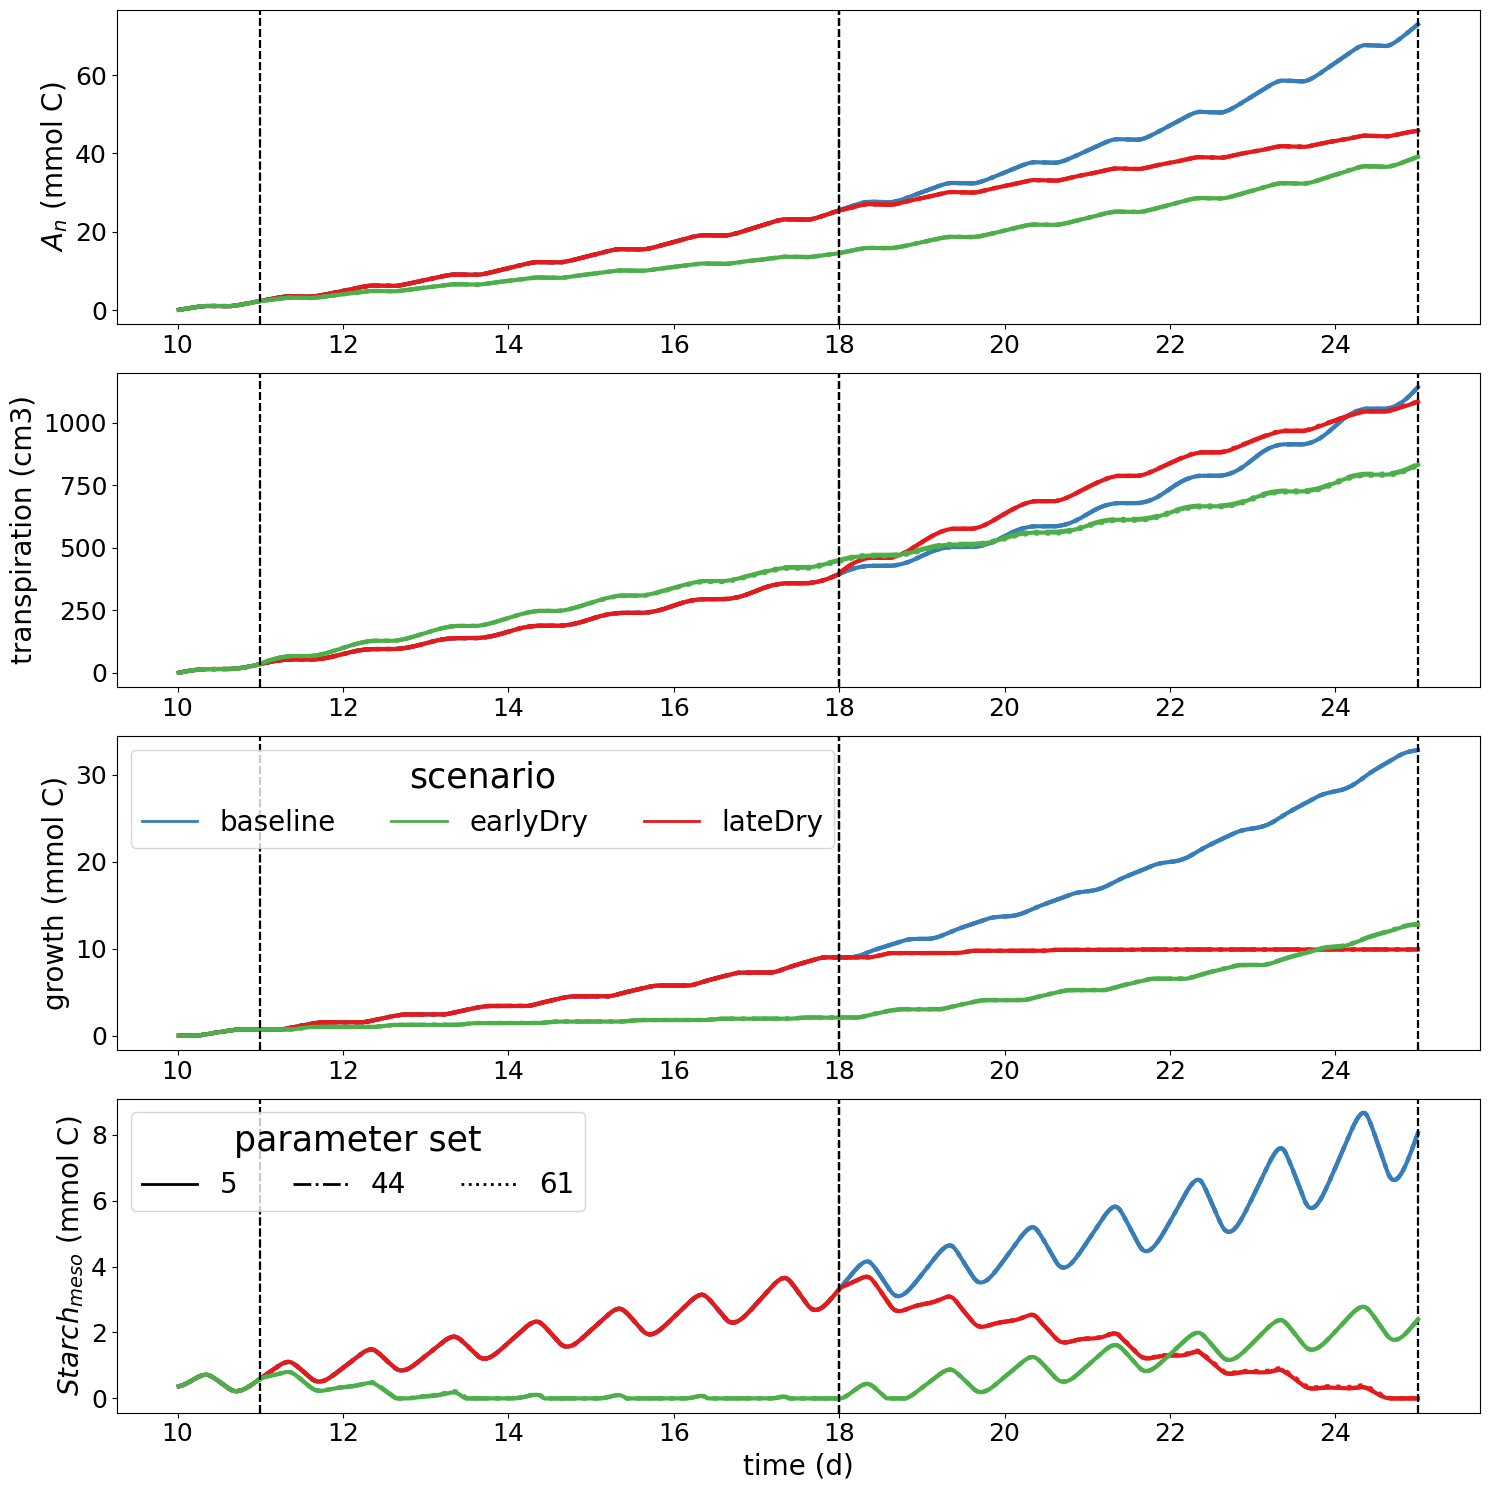

In [78]:

dotheplot(toplot =  ['Q_Ag','trans','Q_Gr', 'Q_S_meso'],
          namesyaxes={'Q_Ag':"$A_n$", 'trans':"transpiration", 'Q_Gr':"growth", 'Q_S_meso': "$Starch_{meso}$"},
          cumsum=True, df=dftemp, sizerows=15,sizecols_=15,ncols=1, indexlegend1=2, indexlegend2=3)

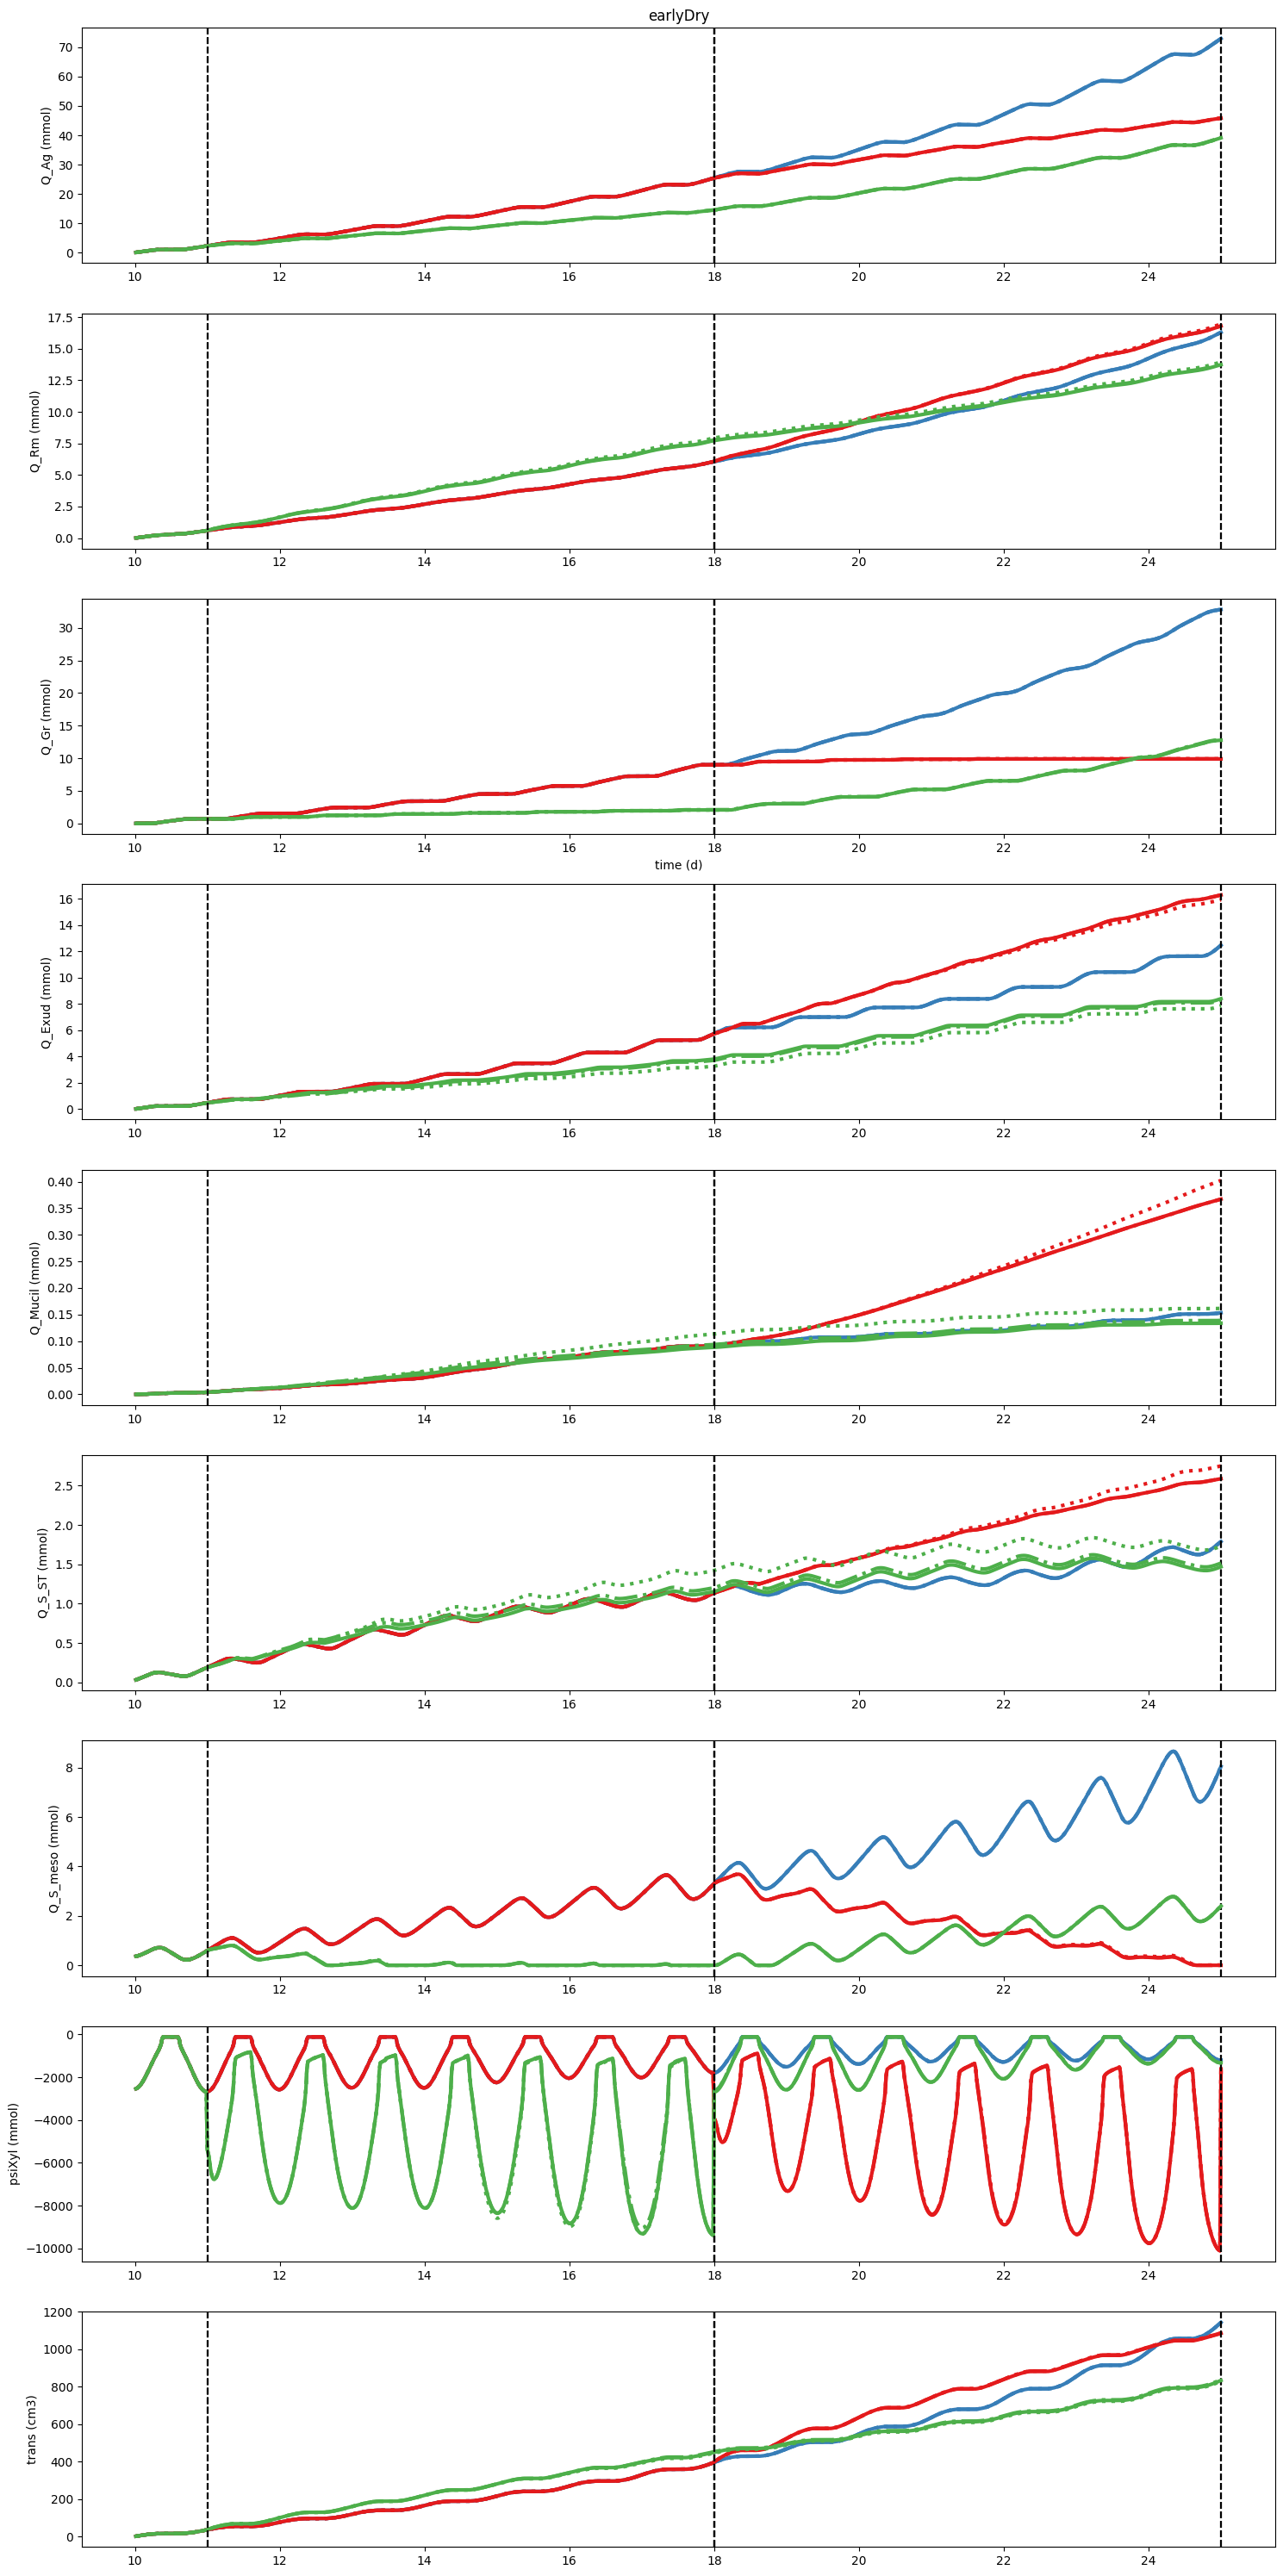

In [37]:

dotheplot(toplot =  ['Q_Ag','Q_Rm','Q_Gr', 'Q_Exud','Q_Mucil', #(toplot, cumsum,df, sizerows,sizecols,ncols=3, maxTime = None):
                     'Q_S_ST', 'Q_S_meso','psiXyl', 'trans'],
          cumsum=True, df=dftemp, sizerows=15,sizecols_=30,ncols=1)

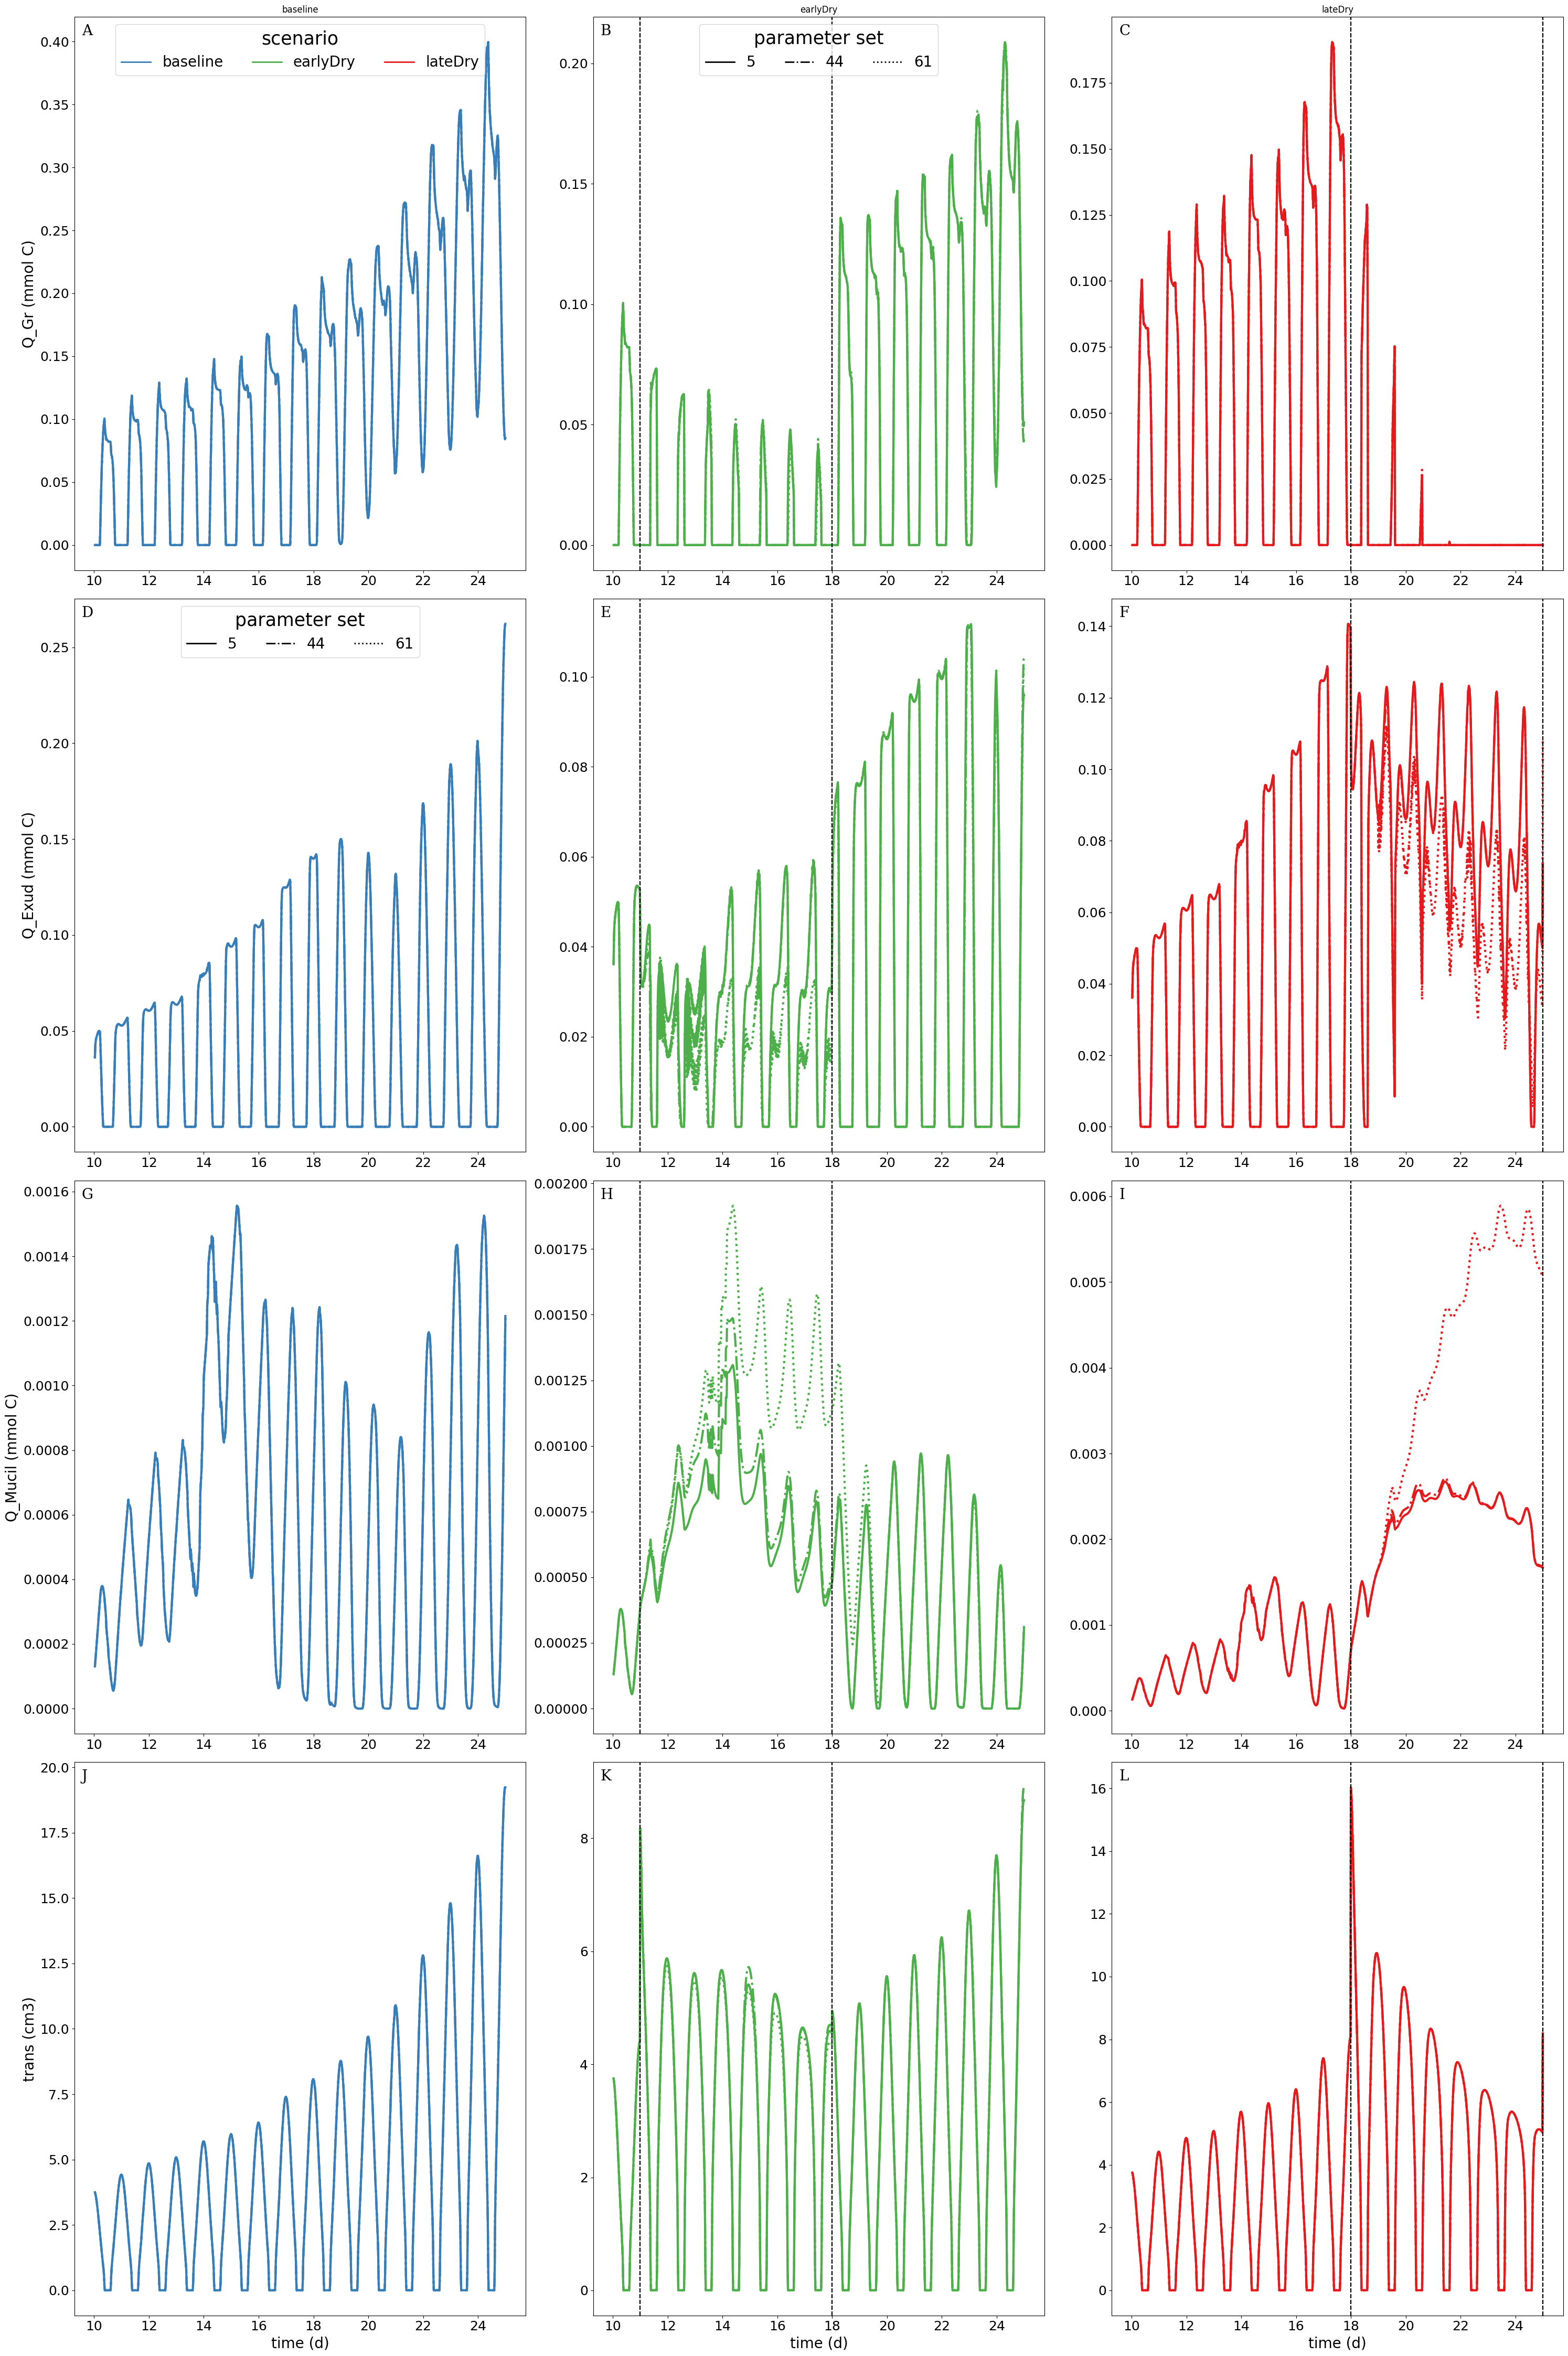

In [37]:

dotheplot(toplot =  ['Q_Gr','Q_Exud','Q_Mucil', 'trans'],
          cumsum=False, df=dftemp, sizerows=30,sizecols_=15)